# Surface code

We still need:
- cleaning the python files of the code classes
- rescaled measurement and gate error rates
- files that generate the 3dplot, Tbiasplot, Gbiasplot, pTpRplot
    - stdin arguments: code, logical, distances, expected error rates, max deviation from expected error rate, resolution params of the plot

In [2]:
from RotatedSurfaceCode import RotatedSurfaceCode
from SurfaceCode3CX import SurfaceCode3CX
from XZZXCode import XZZXCode
from HeavyHEXFloquetColorCode import HeavyHexFloquetColorCode
from HeavyHEXHoneycombFloquetCode import HeavyHexHoneycombFloquetCode
from XYZ2Code import XYZ2Code
import plot_utils

import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.optimize import fsolve
from math import comb


In [3]:
from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

## Thresold estimates for experimental setups

In [36]:
T1 = 3_300 #us
T2 = 50 #T2 of an idling qubit with arbitrary dynamical decoupling protocol 
Fidelity_RO = 0.99
Readout_time = 6
Fidelity_init = 0.995
Init_time = 2
Fidelity_1Q = 0.996
Fidelity_2Q = 0.996

In [37]:
pT1 = (1-np.exp(-(Readout_time+Init_time)/T1))/4 #relaxation, assuming exponential decay
pT2 = (1-np.exp(-(Readout_time+Init_time)**2/T2**2))/2 - (1-np.exp(-(Readout_time+Init_time)/T1))/4 #dephasing, assuming Gaussian decay
pRR = (1-Fidelity_RO)*Fidelity_init + (1-Fidelity_init)*Fidelity_RO
pG1 = 1-Fidelity_1Q
pG2 = 1-Fidelity_2Q

In [66]:
# pR = 15/31*pRR
f = lambda pR: sum([comb(2,i)*(8*pR/15)**i*(1-8*pR/15)**(2-i)*pR**j*(1-pR)**(1-j) for i in range(3) for j in range(2) if i+j%2])-pRR
pR = fsolve(f,pRR)[0]#inverting the formula of pRR(pR)
etaT = pT2/pT1
pT = pT1 + pT2
etaG= pG2/pG1
pG = (pG1 + pG2)/2
p_physR = np.sqrt(pG**2 + pT**2 + pR**2)
phi = np.arctan2(pT,pG)
thetaR = np.arctan2(pR,np.sqrt(pT**2 + pG**2))
p_physR

0.015105700467154563

In [67]:
pG,pT,pR,etaG, etaT

(0.0040000000000000036,
 0.012637549199103038,
 0.00724393103526281,
 1.0,
 19.87724148907833)

### estimating threshold from data

In [68]:
code, dmax, logicals = ['RSC', '17', ['X','Z']]
home_dir = '/Users/het/Library/CloudStorage/Box-Box/SpinQubit_ReadoutProtocols_forErrorCorrection/results_from_ccc/'

In [69]:
LogX_fail_3d_d_p=[]
LogZ_fail_3d_d_p=[]

Full_threshold_data_d_p = json.load(open(home_dir+code+'_full_threshold_plots_3d_logical'+logicals[0]+'_dmax'+dmax+'_maxshots300k_Gbias1_Tbias20_all.json'))
for row in range(len(Full_threshold_data_d_p)):        
    LogX_fail_3d_d_p_col = []
    for col in range(len(Full_threshold_data_d_p[row])):
        theta1, phi1, Log_fail_d_p = Full_threshold_data_d_p[row][col]
        p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
        LogX_fail_3d_d_p_col.append([theta1, phi1, p_threshold, p_threshold_error])
    LogX_fail_3d_d_p.append(LogX_fail_3d_d_p_col)

Full_threshold_data_d_p = json.load(open(home_dir+code+'_full_threshold_plots_3d_logical'+logicals[1]+'_dmax'+dmax+'_maxshots300k_Gbias1_Tbias20_all.json'))
for row in range(len(Full_threshold_data_d_p)):        
    LogZ_fail_3d_d_p_col = []
    for col in range(len(Full_threshold_data_d_p[row])):
        theta1, phi1, Log_fail_d_p = Full_threshold_data_d_p[row][col]
        p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
        LogZ_fail_3d_d_p_col.append([theta1, phi1, p_threshold, p_threshold_error])
    LogZ_fail_3d_d_p.append(LogZ_fail_3d_d_p_col)

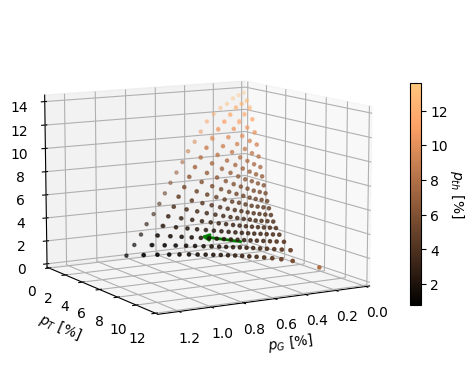

In [84]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

p_physRR = np.sqrt(pG**2 + pT**2 + pRR**2)
thetaRR = np.arctan2(pRR,np.sqrt(pT**2 + pG**2))

a = Arrow3D([0, 100*p_physRR*np.cos(thetaRR)*np.cos(phi)], [0,100*p_physRR*np.cos(thetaRR)*np.sin(phi)],
            [0,100*p_physRR*np.sin(thetaRR)], mutation_scale=10, 
            lw=2, arrowstyle="-|>", color="g")
ax.add_artist(a)
poptlist,pfiterr,std,maxdev = plot_utils.fit_plane(LogX_fail_3d_d_p,LogZ_fail_3d_d_p)
plot_utils.plot_3d_threshold(LogX_fail_3d_d_p,LogZ_fail_3d_d_p,ax=ax,cmap='copper',truncate=False, alpha=0.)
ax.set_xticks(np.arange(0,1.8,0.2))
ax.set_xlim(0,1.3)
ax.set_ylim(0,12)
ax.set_zlim(0,)
# fig.tight_layout()
ax.view_init(elev=10., azim=60)
plt.show()

p_th, p_err =  [0.01406 0.00059]


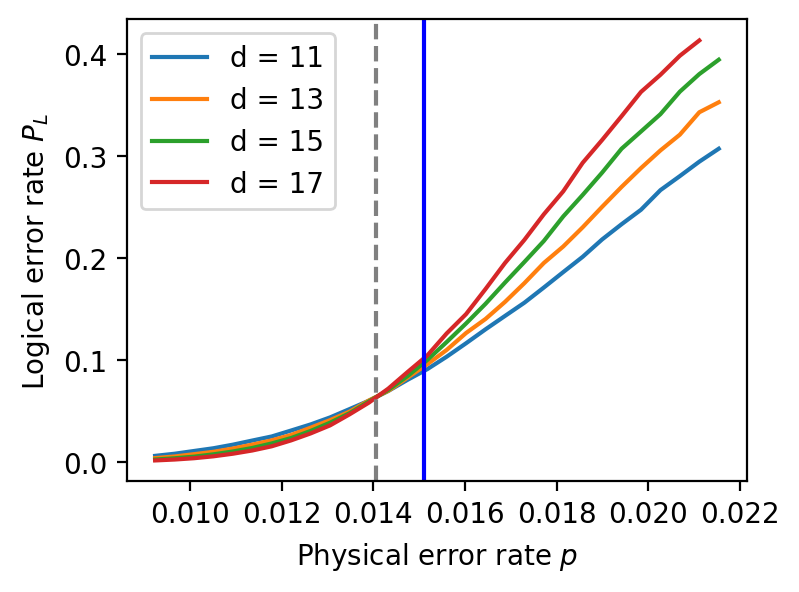

In [71]:
Full_threshold_data_d_p = json.load(open(home_dir+code+'_full_threshold_plots_3d_logical'+logicals[0]+'_dmax'+dmax+'_maxshots300k_Gbias1_Tbias20_all.json'))

nvec_target = np.array([np.cos(thetaR)*np.cos(phi),np.cos(thetaR)*np.sin(phi),np.sin(thetaR)])
overlap = 0
for rowind in range(len(Full_threshold_data_d_p)):
    for colind in range(len(Full_threshold_data_d_p[rowind])):
        theta1, phi1, Log_fail_d_p1 = Full_threshold_data_d_p[rowind][colind]
        nvec1 = np.array([np.cos(theta1)*np.cos(phi1),np.cos(theta1)*np.sin(phi1),np.sin(theta1)])
        if nvec1@nvec_target>overlap:
            # print(theta1,phi1)
            Log_fail_d_p = Log_fail_d_p1
            overlap = nvec1@nvec_target


pth, ptherr = np.round(plot_utils.Threshold_from_LogFail(Log_fail_d_p),5)
print("p_th, p_err = ", np.round([pth, ptherr],5))


fig, ax = plt.subplots(figsize = [4,3],dpi=200)
# plt.loglog()
dist_list = []

for dind in range(len(Log_fail_d_p)):
    xs,ys = np.transpose(Log_fail_d_p[dind][1])
    d = Log_fail_d_p[dind][0]
    plt.plot(xs,ys,'-')
    dist_list.append(Log_fail_d_p[dind][0])
plt.legend(['d = '+str(d) for d in dist_list])

plt.xlabel('Physical error rate $p$')
plt.ylabel('Logical error rate $P_L$')
plt.axvline(p_physR, c='blue')

# plt.xlim(0.005,0.013) v
# plt.ylim(0.003,0.5)
plt.axvline(pth, ls= 'dashed', c='gray')
plt.show()

In [72]:
overlap

0.9987972932850485

### calculating threshold from input

In [73]:
code_distances = range(9,13,2)
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(RotatedSurfaceCode, 
                                                    theta = thetaR, phi = phi, Gbias = etaG, Tbias = etaT, logical = 'X',
                                                    dist_list = code_distances, error_list = np.linspace(0.01,0.02,10), T_over_d = 1,
                                                    max_shots = 100_000, shot_batch = 1_000, max_num_fail = 10_000, max_fail_rate = 0.4
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
print("p_th, p_err = ", np.round([p_threshold, p_threshold_error],5))

p_th, p_err =  [0.01512 0.00067]


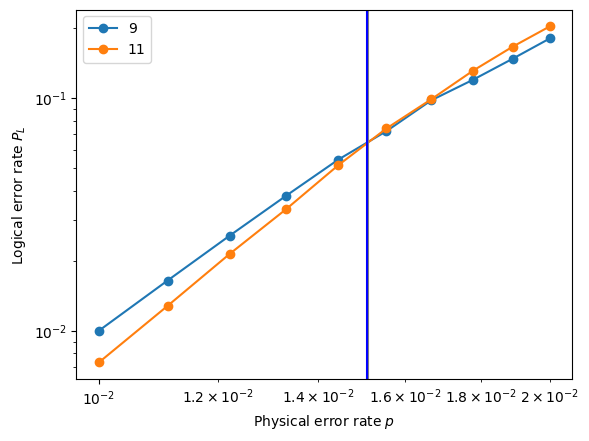

In [74]:
dist_list = [Log_fail_d_p[dind][0] for dind in range(len(Log_fail_d_p))]
fig, ax = plt.subplots(1, 1)
plt.loglog()
for dind in range(len(Log_fail_d_p)):
    xs,ys = np.transpose(Log_fail_d_p[dind][1])
    plt.plot(xs,ys,'o-')
plt.legend(dist_list)
# plt.ylim(1e-7)
# ax.axhline(1/num_shots,c='gray')
# for d in dist_list:
#     plt.plot(xs,0.05*np.array(xs/0.003)**(int(d/2)),'--',c='gray')
# plt.plot(xs,xs)
plt.xlabel('Physical error rate $p$')
plt.ylabel('Logical error rate $P_L$')
plt.axvline(p_threshold, c='gray')
plt.axvline(p_physR, c='blue')
# plt.axvline(p_threshold - p_threshold_error, c='gray')
# plt.axvline(p_threshold + p_threshold_error, c='gray')
plt.show()

## Generating some threshold data for every code

In [2]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(RotatedSurfaceCode, 
                                                    theta = 0, phi = 0, Gbias = 1, Tbias = 20, logical = 'X',
                                                    dist_list = range(3,9,2), error_list = np.linspace(0.001,0.03,10), T_over_d = 1,
                                                    max_shots = 100_000, shot_batch = 1_000, max_num_fail = 10_000, max_fail_rate = 0.4
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

In [ ]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(RotatedSurfaceCode,0,0,1, Tbias = 20, logical = 'X',
                                                    dist_list = range(3,7,2), error_list = np.linspace(0.001,0.03,10), T_over_d = 1,
                                                    max_shots = 100_000, shot_batch = 1_000, max_num_fail = 1_000, max_fail_rate = 0.4
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

In [ ]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(RotatedSurfaceCode, 
                                                    theta = 0, phi = 0, Gbias = 1, Tbias = 20, logical = 'X',
                                                    dist_list = range(3,9,2), error_list = np.linspace(0.001,0.03,10), T_over_d = 1,
                                                    max_shots = 100_000, shot_batch = 1_000, max_num_fail = 1_000, max_fail_rate = 0.4
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0.01589216192937123

In [14]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(SurfaceCode3CX, 
                                                    theta = np.pi/2, phi = 0, Gbias = 1, Tbias = 20, logical = 'X',
                                                    dist_list = range(3,9,2), error_list = np.linspace(0.001,0.1,10), T_over_d = 1,
                                                    max_shots = 100_000, shot_batch = 1_000, max_num_fail = 10_000, max_fail_rate = 0.4
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0.05745908797665563

In [10]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(SurfaceCode3CX, 
                                                    theta = np.pi/2, phi = 0, Gbias = 1, Tbias = 20, logical = 'X',
                                                    dist_list = range(3,9,2), error_list = np.linspace(0.001,0.1,10), T_over_d = 0.5,
                                                    max_shots = 100_000, shot_batch = 1_000, max_num_fail = 10_000, max_fail_rate = 0.4
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0.06011518667375177

In [2]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(XZZXCode, 
                                                    theta = 0, phi = 0, Gbias = 1, Tbias = 20, logical = 'X',
                                                    dist_list = range(3,9,2), error_list = np.linspace(0.001,0.03,10), T_over_d = 1,
                                                    max_shots = 100_000, shot_batch = 1_000, max_num_fail = 10_000, max_fail_rate = 0.4
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0.009653389238294896

In [8]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(XYZ2Code, 
                                                    theta = 0, phi = np.pi/2, Gbias = 1, Tbias = 20, logical = 'Z',
                                                    dist_list = range(7,11,2), error_list = np.linspace(0.001,0.1,10), T_over_d = 1,
                                                    max_shots = 10_000, shot_batch = 1_000, max_num_fail = 1_000, max_fail_rate = 0.4,
                                                    dedicated_link = 'X'
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0.023670360110803326

In [7]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(XYZ2Code, 
                                                    theta = 0, phi = np.pi/2, Gbias = 1, Tbias = 20, logical = 'Y',
                                                    dist_list = range(7,11,2), error_list = np.linspace(0.001,0.1,10), T_over_d = 1,
                                                    max_shots = 10_000, shot_batch = 1_000, max_num_fail = 1_000, max_fail_rate = 0.4,
                                                    dedicated_link = 'Z'
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0.04235176103432902

In [5]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(HeavyHexFloquetColorCode,
                                                    theta = 0, phi = 0, Gbias = 1, Tbias = 20, logical = 'X',
                                                    dist_list = range(1,4,1), error_list = np.linspace(0.001,0.03,10), T_over_d = 1,
                                                    max_shots = 30_000, shot_batch = 1_000, max_num_fail = 10_000, max_fail_rate = 0.4,
                                                    noSWAP = False
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0.009335823550337958

In [3]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(HeavyHexFloquetColorCode,
                                                    theta = 0, phi = 0, Gbias = 1, Tbias = 20, logical = 'X',
                                                    dist_list = range(1,4,1), error_list = np.linspace(0.001,0.03,10), T_over_d = 1,
                                                    max_shots = 30_000, shot_batch = 1_000, max_num_fail = 10_000, max_fail_rate = 0.4,
                                                    noSWAP = True
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0.010666666666666665

In [8]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(HeavyHexHoneycombFloquetCode,
                                                    theta = 0, phi = 0, Gbias = 1, Tbias = 20, logical = 'X',
                                                    dist_list = range(1,4,1), error_list = np.linspace(0.001,0.03,10), T_over_d = 1,
                                                    max_shots = 30_000, shot_batch = 1_000, max_num_fail = 10_000, max_fail_rate = 0.4,
                                                    noSWAP = True
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0.01132494258964847

In [9]:
%matplotlib inline

In [29]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(SurfaceCode3CX, 
                                                    theta = 0, phi = np.pi/2, Gbias = 1, Tbias = 20, logical = 'X',
                                                    dist_list = range(5,11,2), error_list = np.linspace(0.001,0.15,10), T_over_d = 1,
                                                    max_shots = 100_000, shot_batch = 1_000, max_num_fail = 10_000, max_fail_rate = 0.4
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0

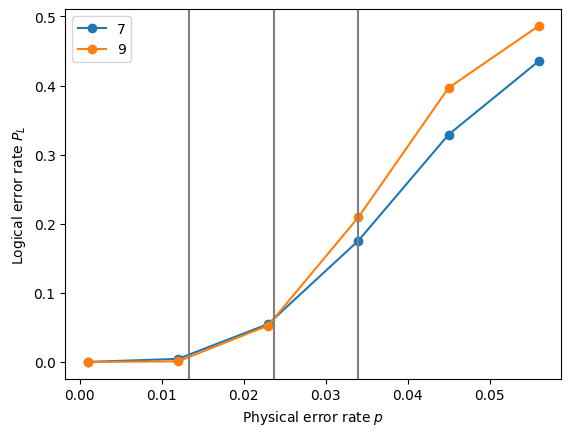

In [9]:
dist_list = [Log_fail_d_p[dind][0] for dind in range(len(Log_fail_d_p))]
fig, ax = plt.subplots(1, 1)
# plt.loglog()
for dind in range(len(Log_fail_d_p)):
    xs,ys = np.transpose(Log_fail_d_p[dind][1])
    plt.plot(xs,ys,'o-')
plt.legend(dist_list)
# plt.ylim(1e-7)
# ax.axhline(1/num_shots,c='gray')
# for d in dist_list:
#     plt.plot(xs,0.05*np.array(xs/0.003)**(int(d/2)),'--',c='gray')
# plt.plot(xs,xs)
plt.xlabel('Physical error rate $p$')
plt.ylabel('Logical error rate $P_L$')
plt.axvline(p_threshold, c='gray')
plt.axvline(p_threshold - p_threshold_error, c='gray')
plt.axvline(p_threshold + p_threshold_error, c='gray')
plt.show()

## Bias plots

In [4]:
%matplotlib widget

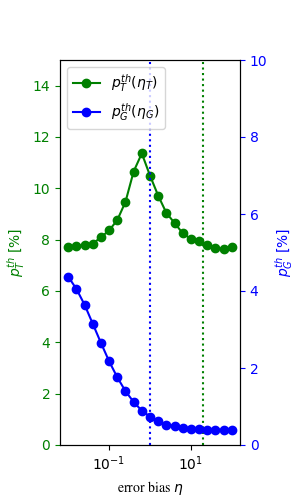

In [12]:
code, dmax, logicals = ['SC3', '17', ['X','Z']]
home_dir = '/Users/het/Library/CloudStorage/Box-Box/SpinQubit_ReadoutProtocols_forErrorCorrection/results_from_ccc/'


LogX_fail_Tbias_threshold = json.load(open(home_dir+code+'_threshold_Tbias_logical'+logicals[0]+'_dmax'+dmax+'_maxshots300k_Gbias1.json'))
LogZ_fail_Tbias_threshold = json.load(open(home_dir+code+'_threshold_Tbias_logical'+logicals[1]+'_dmax'+dmax+'_maxshots300k_Gbias1.json'))

LogX_fail_Gbias_threshold = json.load(open(home_dir+code+'_threshold_Gbias_logical'+logicals[0]+'_dmax'+dmax+'_maxshots300k_Tbias20.json'))
LogZ_fail_Gbias_threshold = json.load(open(home_dir+code+'_threshold_Gbias_logical'+logicals[1]+'_dmax'+dmax+'_maxshots300k_Tbias20.json'))

Tbias,pT_threshold1,pT_error = np.transpose(LogX_fail_Tbias_threshold)
Tbias,pT_threshold2,pT_error = np.transpose(LogZ_fail_Tbias_threshold)
for pind in range(len(pT_threshold1)):
    if pT_threshold1[pind]==0:
        pT_threshold1[pind] = pT_threshold2[pind]
    if pT_threshold2[pind]==0:
        pT_threshold2[pind] = pT_threshold1[pind]
pT_threshold = np.array([min(pT_threshold1[pind],pT_threshold2[pind]) for pind in range(len(pT_threshold1))])

Gbias,pG_threshold1,pT_error = np.transpose(LogX_fail_Gbias_threshold)
Gbias,pG_threshold2,pT_error = np.transpose(LogZ_fail_Gbias_threshold)
for pind in range(len(pG_threshold1)):
    if pG_threshold1[pind]==0:
        pG_threshold1[pind] = pG_threshold2[pind]
    if pG_threshold2[pind]==0:
        pG_threshold2[pind] = pG_threshold1[pind]
pG_threshold = np.array([min(pG_threshold1[pind],pG_threshold2[pind]) for pind in range(len(pG_threshold1))])

pTmin,pTmax = 100*min(pT_threshold)[0],100*max(pT_threshold)[0]
pGmin,pGmax = 100*min(pG_threshold)[0],100*max(pG_threshold)[0]

fig, ax = plt.subplots(figsize = [3,5])
# fig, ax = plt.subplots(figsize = [7,5])
fig.subplots_adjust(left=0.2,right=0.8)
ax1 = ax.twinx()

p1, = ax.plot(Tbias,pT_threshold*100,'o-',c='g',label = '$p_T^{th}(\eta_T)$')
p2, = ax1.plot(Gbias,pG_threshold*100,'o-',c='b', label = '$p_G^{th}(\eta_G)$')
ax.semilogx()
ax.legend(handles=[p1,p2], loc = 'upper left')
ax.set_ylim(0,15) 
ax1.set_ylim(0,10)
ax.axvline(20, linestyle = 'dotted', c='green')
ax.axvline(1, linestyle = 'dotted', c='blue')

ax.tick_params(axis='y', colors=p1.get_color())
ax1.tick_params(axis='y', colors=p2.get_color())
ax.set_xlabel('error bias $\eta$', fontfamily = 'times')
ax.set_ylabel('$p_T^{th}$ [%]', c=p1.get_color())
ax1.set_ylabel('$p_G^{th}$ [%]', c=p2.get_color())
plt.show()

In [10]:
##only works in widget mode...
plt.savefig("/Users/het/Library/CloudStorage/Box-Box/SpinQubit_ReadoutProtocols_forErrorCorrection/main/Figures/pGpT_vs_bias_"+code+".pdf")

### Threshold plot

bias, pth, perr =  (0.07718131720517545, 0.004873624897483136)


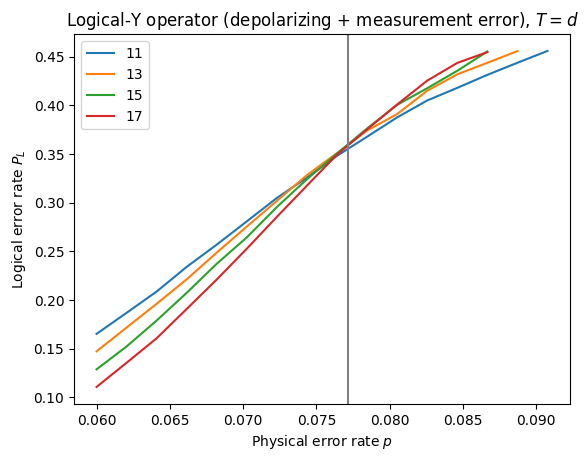

In [18]:
# Log_fail_threshold = json.load(open(home_dir+code+'_threshold_Gbias_logical'+logicals[0]+'_dmax'+dmax+'_maxshots300k_Tbias20.json'))
# Full_threshold_data_d_p = json.load(open(home_dir+code+'_full_threshold_plots_Gbias_logical'+logicals[0]+'_dmax'+dmax+'_maxshots300k_Tbias20.json'))

# Log_fail_threshold = json.load(open(home_dir+code+'_threshold_Tbias_logical'+logicals[1]+'_dmax'+dmax+'_maxshots300k_Gbias1.json'))
Full_threshold_data_d_p = json.load(open(home_dir+code+'_full_threshold_plots_Tbias_logical'+logicals[0]+'_dmax'+dmax+'_maxshots300k_Gbias1.json'))

rowind = 20
Log_fail_d_p = Full_threshold_data_d_p[0][rowind][1]
# threshold_data=  Log_fail_threshold[0][rowind]
threshold_data = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
print("bias, pth, perr = ", threshold_data)


fig, ax = plt.subplots(1, 1)
# plt.loglog()
dist_list = []
for dind in range(len(Log_fail_d_p)):
    xs,ys = np.transpose(Log_fail_d_p[dind][1])
    plt.plot(xs,ys,'-')
    dist_list.append(Log_fail_d_p[dind][0])
plt.legend(dist_list)
plt.title('Logical-Y operator (depolarizing + measurement error), $T = d$')
plt.xlabel('Physical error rate $p$')
plt.ylabel('Logical error rate $P_L$')
# plt.xlim(0.03,0.06)
# plt.ylim(0.0,0.1)
plt.axvline(threshold_data[0], c='gray')
# plt.text(0.005,1e-3,"0.0055")
plt.show()

## 3D threshold surface

In [6]:
LogX_fail_3d_d_p=[]
LogZ_fail_3d_d_p=[]

Full_threshold_data_d_p = json.load(open(home_dir+code+'_full_threshold_plots_3d_logical'+logicals[0]+'_dmax'+dmax+'_maxshots300k_Gbias1_Tbias20_all.json'))
for row in range(len(Full_threshold_data_d_p)):        
    LogX_fail_3d_d_p_col = []
    for col in range(len(Full_threshold_data_d_p[row])):
        theta, phi, Log_fail_d_p = Full_threshold_data_d_p[row][col]
        p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
        LogX_fail_3d_d_p_col.append([theta, phi, p_threshold, p_threshold_error])
    LogX_fail_3d_d_p.append(LogX_fail_3d_d_p_col)

Full_threshold_data_d_p = json.load(open(home_dir+code+'_full_threshold_plots_3d_logical'+logicals[1]+'_dmax'+dmax+'_maxshots300k_Gbias1_Tbias20_all.json'))
for row in range(len(Full_threshold_data_d_p)):        
    LogZ_fail_3d_d_p_col = []
    for col in range(len(Full_threshold_data_d_p[row])):
        theta, phi, Log_fail_d_p = Full_threshold_data_d_p[row][col]
        p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
        LogZ_fail_3d_d_p_col.append([theta, phi, p_threshold, p_threshold_error])
    LogZ_fail_3d_d_p.append(LogZ_fail_3d_d_p_col)

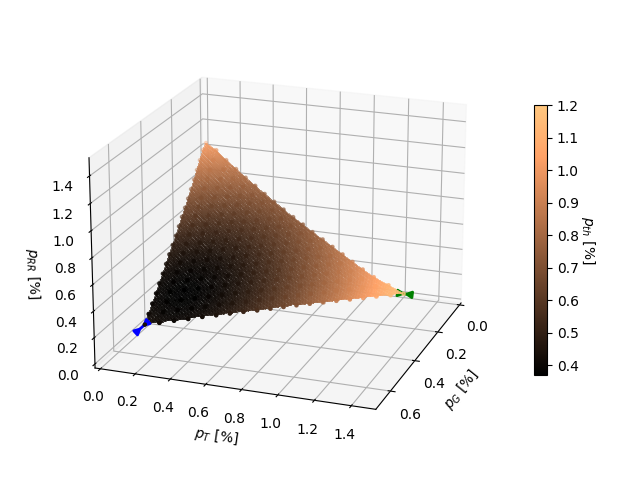

In [7]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

a = Arrow3D([pGmin, pGmax], [0, 0], 
            [0, 0], mutation_scale=10, 
            lw=2, arrowstyle="<|-|>", color="b")
# a = Arrow3D([pGmin, 1.3], [0, 0], 
#             [0, 0], mutation_scale=10, 
#             lw=2, arrowstyle="<|-", color="b")
ax.add_artist(a)
a = Arrow3D([0, 0], [pTmin, pTmax],
            [0, 0], mutation_scale=10, 
            lw=2, arrowstyle="<|-|>", color="g")
ax.add_artist(a)


poptlist,pfiterr,std,maxdev = plot_utils.fit_plane(LogX_fail_3d_d_p,LogZ_fail_3d_d_p)
plot_utils.plot_3d_threshold(LogX_fail_3d_d_p,LogZ_fail_3d_d_p,ax=ax,cmap='copper',truncate=False, alpha=0.5)
# ax.plot_trisurf([poptlist[0],0,0],[0,poptlist[1],0],[0,0,poptlist[2]],color='gray', alpha= 0.2)

# ax.set_title('Rotated surface code')
ax.set_xticks(np.arange(0,1.8,0.2))
ax.set_xlim(0,.7)
ax.set_ylim(0,1.5)
ax.set_zlim(0,1.5)
fig.tight_layout()
plt.show()

In [8]:
##only works in widget mode...
plt.savefig("/Users/het/Library/CloudStorage/Box-Box/SpinQubit_ReadoutProtocols_forErrorCorrection/main/Figures/3D_threshold_"+code+".pdf")

In [9]:
poptlist,pfiterr,std,maxdev = plot_utils.fit_plane(LogX_fail_3d_d_p,LogX_fail_3d_d_p)
print('pG = '+str(np.round(poptlist[0],3))+'+\-'+str(np.round(pfiterr[0],3))
      +'  pT = '+str(np.round(poptlist[1],3))+'+\-'+str(np.round(pfiterr[1],3))
      +'  pR = '+str(np.round(poptlist[2],3))+'+\-'+str(np.round(pfiterr[2],3))
      +'\n  pic = '+str(np.round((1/poptlist[0]+1/poptlist[1]+1/poptlist[2])**(-1),3))
      +'  pph = '+str(np.round((1/poptlist[1]+1/poptlist[2])**(-1),3)))
print('<(dpth\pth)^2> = '+str(np.round(std,3))+' max(dpth\pth) = '+str(np.round(maxdev,3)))

pG = 0.43+\-0.002  pT = 1.159+\-0.002  pR = 0.985+\-0.002
  pic = 0.238  pph = 0.532
<(dpth\pth)^2> = 0.015 max(dpth\pth) = 0.051


### Threshold plots

p_th, p_err =  [0. 0.]


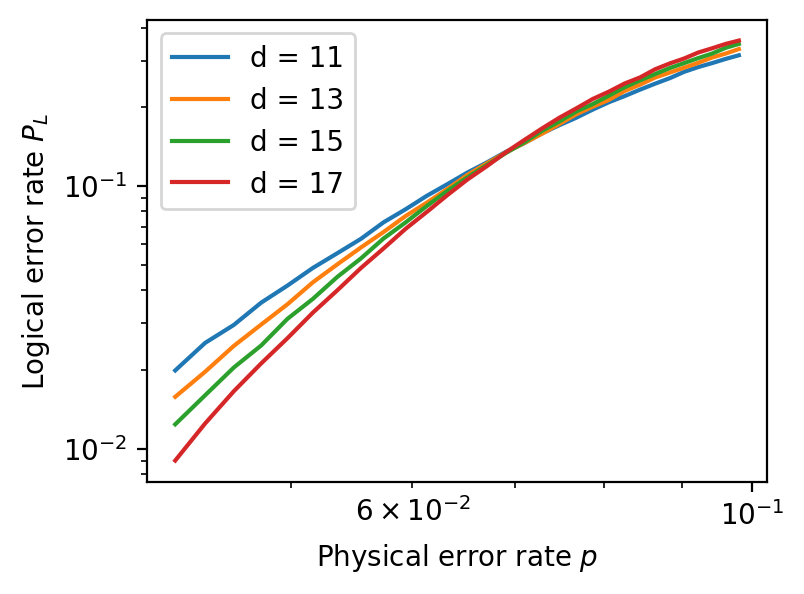

In [23]:
#Full_threshold_data_d_p = json.load(open(home_dir+code+'_full_threshold_plots_3d_logical'+logicals[0]+'_dmax'+dmax+'_maxshots300k_Gbias1_Tbias20_all.json'))

rowind = 0
colind = -1
theta1, phi1, Log_fail_d_p = Full_threshold_data_d_p[rowind][colind]
pth, ptherr = np.round(plot_utils.Threshold_from_LogFail(Log_fail_d_p))
print("p_th, p_err = ", np.round([pth, ptherr],5))


fig, ax = plt.subplots(figsize = [4,3],dpi=200)
plt.loglog()
dist_list = []

for dind in range(len(Log_fail_d_p)):
    xs,ys = np.transpose(Log_fail_d_p[dind][1])
    d = Log_fail_d_p[dind][0]
    plt.plot(xs,ys,'-')
    # plt.plot(xs,(1-(1-2*ys)**(1/d))/2,'o-')
    dist_list.append(Log_fail_d_p[dind][0])
plt.legend(['d = '+str(d) for d in dist_list])
# plt.title('Logical-Y operator (depolarizing + measurement error), $T = d$')
plt.xlabel('Physical error rate $p$')
plt.ylabel('Logical error rate $P_L$')
# plt.xlim(0.005,0.013)
# plt.ylim(0.003,0.5)
plt.axvline(pth, ls= 'dashed', c='gray')
plt.show()

## Optimal readout time

In [9]:
from math import comb

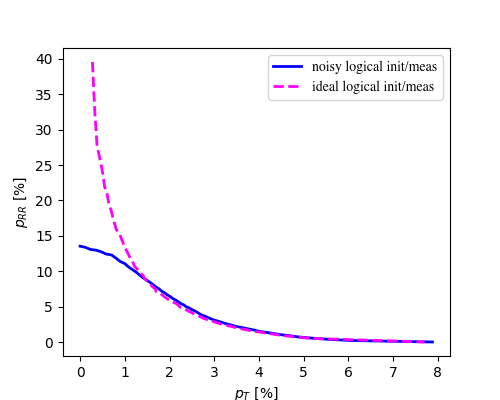

In [10]:
Log_fail_noisy_theta_threshold = json.load(open(home_dir+'RSC_pTpR_threshold_logicalX_dmax17_maxshots300k_Gbias1_Tbias20_noisyLogRO_True.json'))[0]
Log_fail_ideal_theta_threshold = json.load(open(home_dir+'RSC_pTpR_threshold_pG0_logicalX_dmax17_maxshots300k_Gbias1_Tbias20_noisyLogRO_False.json'))[0]


phi = np.pi/2
pT_id_list = []
pR_id_list = []
for rowind in range(len(Log_fail_ideal_theta_threshold)):
    theta, phi, p_threshold, p_error = Log_fail_ideal_theta_threshold[rowind]
    pR = p_threshold*np.sin(theta)
    pm = sum([comb(2,i)*(8*pR/15)**i*(1-8*pR/15)**(2-i)*pR**j*(1-pR)**(1-j) for i in range(3) for j in range(2) if i+j%2])
    if p_threshold>0:
        pT_id_list.append(p_threshold*np.cos(theta)*np.sin(phi)*100)
        pR_id_list.append(pm*100)

pT_no_list = []
pR_no_list = []
for rowind in range(len(Log_fail_noisy_theta_threshold)):
    theta, phi, p_threshold, p_error = Log_fail_noisy_theta_threshold[rowind]
    pR = p_threshold*np.sin(theta)
    pm = sum([comb(2,i)*(8*pR/15)**i*(1-8*pR/15)**(2-i)*pR**j*(1-pR)**(1-j) for i in range(3) for j in range(2) if i+j%2])
    pT_no_list.append(p_threshold*np.cos(theta)*np.sin(phi)*100)
    pR_no_list.append(pm*100)


fig, ax = plt.subplots(figsize=[5,4])

ax.plot(pT_no_list,pR_no_list,'-',c='b',lw=2)
ax.plot(pT_id_list,pR_id_list,'--',c='magenta',lw=2)
# plt.plot(pT_no_list,pT_no_list,'-',c='gray',alpha=0.5)

# plt.semilogx()
# plt.loglog()
# plt.ylim(0,5) 
ax.set_xlabel('$p_T$ [%]')
ax.set_ylabel('$p_{RR}$ [%]')
ax.legend(['noisy logical init/meas','ideal logical init/meas'],prop={'family':'times'})
plt.show()

In [ ]:
plt.savefig("/Users/het/Library/CloudStorage/Box-Box/SpinQubit_ReadoutProtocols_forErrorCorrection/main/Figures/pRvspT_threshold_RSC.pdf")

In [11]:
#showing-off values
T2, Tinit, pinit, TSNR, T1RO = 50., 3, 0.005, 1.5, 1000
#more sensible vlaues
# T2, Tinit, pinit, TSNR, T1RO = 10., 1, 0.01, .3, 20

pG = 0.001
pGth, pTth, pRth = 0.0082, 0.0394, 0.145

pT_list = np.linspace(0,.08,100)
pTth_list = np.linspace(0,pTth*(1-pG/pGth),100)
pRth_list = np.linspace(pRth*(1-pG/pGth),0,100)

tau_list = T2*np.sqrt(-np.log(1-2*pT_list))-Tinit
pR_of_pT = 1-(1-np.exp(-tau_list/TSNR))*np.exp(-tau_list/T1RO)
pRR_of_pT = pR_of_pT*(1-pinit) + (1- pR_of_pT)*pinit


p_phys_over_pth = pG/pGth + pT_list/pTth + pRR_of_pT/pRth
print(min(p_phys_over_pth[1:-1]),(p_phys_over_pth)[np.argmin(pRR_of_pT)])

tQEC,texp = tau_list[np.argmin(p_phys_over_pth)],tau_list[np.argmin(pRR_of_pT)]
pRth, pTth = max(pRth_list), max(pTth_list)
#approximate formulas
texp2 = TSNR*np.log(1+T1RO/TSNR)
tQEC2 = texp2 - TSNR*np.log(1+pRth/pTth/(1-2*pinit)*T1RO*(texp2+Tinit)/T2**2)
for i in range(10):
    tQEC2 = texp2 - TSNR*np.log(1+pRth/pTth/(1-2*pinit)*T1RO*(tQEC2+Tinit)/T2**2)
pTexp = (1-np.exp(-(texp2+Tinit)**2/T2**2))/2
pTQEC = (1-np.exp(-(tQEC2+Tinit)**2/T2**2))/2
print(tQEC/tQEC2,texp/texp2)

pRQEC = 1-(1-np.exp(-tQEC2/TSNR))*np.exp(-tQEC2/T1RO)
pRRQEC = pRQEC*(1-pinit) + (1- pRQEC)*pinit
pRexp = 1-(1-np.exp(-texp2/TSNR))*np.exp(-texp2/T1RO)
pRRexp = pRexp*(1-pinit) + (1- pRexp)*pinit

0.7250405240516824 1.0327216156790553
1.0069916569700417 1.0002144666623585


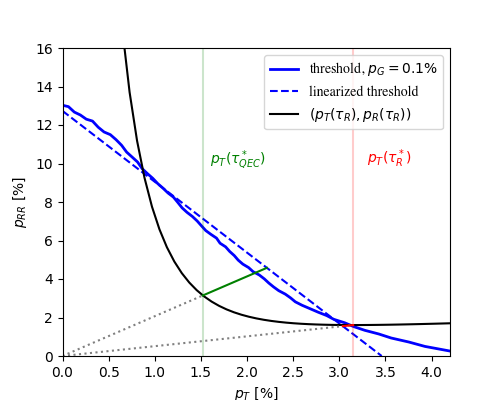

In [12]:
Log_fail_noisy_theta_threshold = json.load(open(home_dir+'RSC_pTpR_threshold_pG001_logicalX_dmax17_maxshots300k_Gbias1_Tbias20_noisyLogRO_True.json'))[0]

pT_no_list = []
pR_no_list = []
for rowind in range(len(Log_fail_noisy_theta_threshold)):
    theta, phi, p_threshold, p_error = Log_fail_noisy_theta_threshold[rowind]
    pR = p_threshold*np.sin(theta)
    pm = sum([comb(2,i)*(8*pR/15)**i*(1-8*pR/15)**(2-i)*pR**j*(1-pR)**(1-j) for i in range(3) for j in range(2) if i+j%2])
    pT_no_list.append(p_threshold*np.cos(theta)*np.sin(phi)*100)
    pR_no_list.append(pm*100)

plt.figure(figsize=[5,4])

plt.plot(pT_no_list,pR_no_list,'-',c='b',lw=2)
plt.plot(100*pTth_list,100*pRth_list,'--',c='blue')
plt.plot(100*pT_list,100*pRR_of_pT,c='black')

plt.plot([0,100*pTQEC],[0,100*pRRQEC], ls='dotted',c='gray')
plt.plot([100*pTQEC,100*pRth/(pRRQEC/pTQEC+pRth/pTth)],[100*pRRQEC, 100*pRRQEC/pTQEC*pRth/(pRRQEC/pTQEC+pRth/pTth)],c='green')
plt.plot([0,100*pTexp],[0,100*pRRexp], ls='dotted',c='gray')
plt.plot([100*pTexp,100*pRth/(pRRexp/pTexp+pRth/pTth)],[100*pRRexp, 100*pRRexp/pTexp*pRth/(pRRexp/pTexp+pRth/pTth)],c='red')

plt.ylim(0,100*.16)
plt.xlim(0,4.2)
plt.axvline(100*pTQEC,ls = 'solid',c='green', alpha = 0.2)
plt.axvline(100*pTexp,ls = 'solid',c='red', alpha = 0.2)
plt.xlabel('$p_T\\ [\%]$')
plt.ylabel('$p_{RR}\\ [\%]$')
plt.text(1.6,10,'$p_T(\\tau^*_{QEC})$',c='green')
plt.text(3.3,10,'$p_T(\\tau^*_R)$',c='red')
# plt.legend(['$1-\mathcal{F}_R (\\tau_R)$','$(1-p_T/p^{th}_T)p^{th}_R$'])
plt.legend(['threshold, $p_G = 0.1\%$', 'linearized threshold', '$(p_T(\\tau_R),p_R(\\tau_R))$'],prop={'family':'times'})
plt.show()

In [28]:
##only works in widget mode...
plt.savefig("/Users/het/Library/CloudStorage/Box-Box/SpinQubit_ReadoutProtocols_forErrorCorrection/main/Figures/optimal_readout_time.pdf")

In [31]:
texp2, tQEC2, min(pR_of_pT), min(pRR_of_pT)

(9.755683570496561,
 5.789641446839995,
 0.011191465507980891,
 0.01607955085290108)

bias, pth, perr =  [1.5518910164121893, 1.5707963267948966, 0.17780924716810045, 0.00441254565582605]


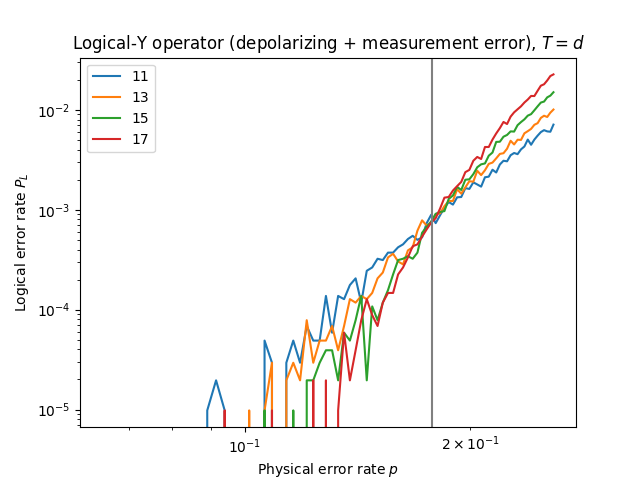

In [284]:
# Log_fail_threshold = json.load(open(home_dir+'RSC_pTpR_threshold_pG001_logicalX_dmax17_maxshots300k_Gbias1_Tbias20_noisyLogRO_True.json'))
# Full_threshold_data_d_p = json.load(open(home_dir+'RSC_pTpR_full_threshold_pG001_plots_logicalX_dmax17_maxshots300k_Gbias1_Tbias20_noisyLogRO_True.json'))
Log_fail_threshold = json.load(open(home_dir+'RSC_pTpR_threshold_pG0_logicalX_dmax17_maxshots100k_Gbias1_Tbias20_noisyLogRO_False.json'))
Full_threshold_data_d_p = json.load(open(home_dir+'RSC_pTpR_full_threshold_pG0_plots_logicalX_dmax17_maxshots100k_Gbias1_Tbias20_noisyLogRO_False.json'))

rowind = 3
print("bias, pth, perr = ", Log_fail_threshold[0][rowind])
Log_fail_d_p = Full_threshold_data_d_p[0][rowind][2]

fig, ax = plt.subplots(1, 1)
plt.loglog()
dist_list = []
for dind in range(len(Log_fail_d_p)):
    xs,ys = np.transpose(Log_fail_d_p[dind][1])
    plt.plot(xs,ys,'-')
    dist_list.append(Log_fail_d_p[dind][0])
plt.legend(dist_list)
plt.title('Logical-Y operator (depolarizing + measurement error), $T = d$')
plt.xlabel('Physical error rate $p$')
plt.ylabel('Logical error rate $P_L$')
# plt.xlim(0.03,0.06)
# plt.ylim(0.0,0.1)
plt.axvline(Log_fail_threshold[0][rowind][2], c='gray')
# plt.text(0.005,1e-3,"0.0055")
plt.show()

## Drawing the qubit lattice and or the connectivity map

In [2]:
%matplotlib widget 
#for nicer png exports

red : round 0
green : round 1
blue : round 2
purple : round 3


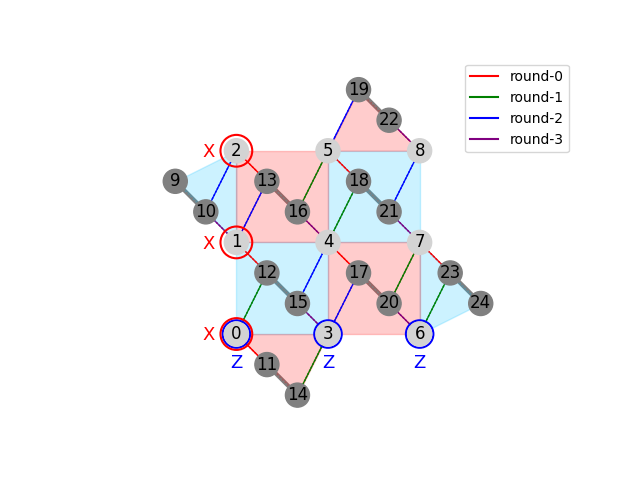

In [3]:
code = SurfaceCodeSpinCircuitNoisyLogRO(d=3, T = 3,logical_observable='X', gate_error_1q=0.001)
# code.draw_lattice()
code.draw_lattice(boundaries = True, connectivity = True, schedule = True, logicals=True)

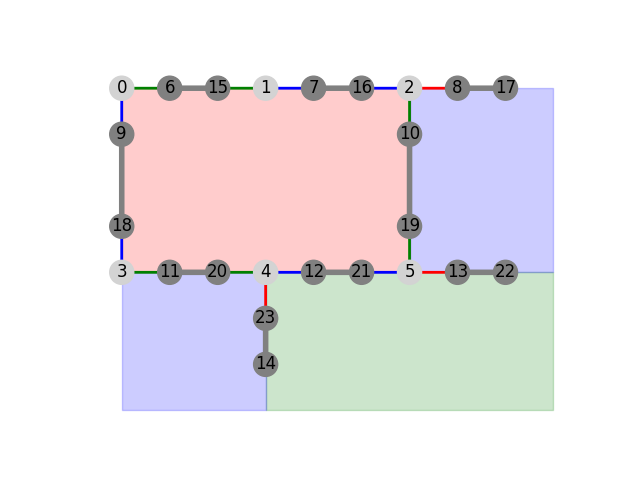

In [6]:
HeavyHexFloquetColorCode(d=2).draw_lattice()